In [1]:
!pip install tensorflow

In [2]:
import pandas as pd
import numpy as np
import os
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as L
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

2025-11-09 11:26:10.078853: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Data processing functions
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

def zcr(data, frame_length, hop_length):
    zcr = librosa.feature.zero_crossing_rate(data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)

def rmse(data, frame_length=2048, hop_length=512):
    # Updated to match the newer librosa version
    rms = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rms)

def mfcc(data, sr, frame_length=2048, hop_length=512, flatten=True):
    mfcc = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc.T) if not flatten else np.ravel(mfcc.T)

def extract_features(data, sr=22050, frame_length=2048, hop_length=512):
    result = np.array([])
    result = np.hstack((result, zcr(data, frame_length, hop_length), rmse(data, frame_length, hop_length), mfcc(data, sr, frame_length, hop_length)))
    return result

def get_features(path, duration=2.5, offset=0.6):
    data, sr = librosa.load(path, duration=duration, offset=offset)
    aud = extract_features(data)
    audio = np.array(aud)
    
    noised_audio = noise(data)
    aud2 = extract_features(noised_audio)
    audio = np.vstack((audio, aud2))
    
    pitched_audio = pitch(data, sr)
    aud3 = extract_features(pitched_audio)
    audio = np.vstack((audio, aud3))
    
    pitched_noised_audio = noise(pitch(data, sr))
    aud4 = extract_features(pitched_noised_audio)
    audio = np.vstack((audio, aud4))
    
    return audio

In [5]:
# --- UNZIP ALL DATASETS AUTOMATICALLY (for SCC project structure) ---
import os, zipfile, glob

# Root path for your Kaggle-style folder inside project space
root = "/projectnb/ds340/projects/Fall_2025_Wrenn_Hear_Me_Out/kaggle/input"

# Ensure root exists
if not os.path.exists(root):
    raise FileNotFoundError(f"Root path not found: {root}")

# Find all .zip files recursively
zips = glob.glob(os.path.join(root, "**", "*.zip"), recursive=True)

print(f"Found {len(zips)} zip file(s) under {root}\n")

# Extract each zip file in-place
for z in zips:
    dest = os.path.dirname(z)
    print(f"→ Unzipping: {os.path.basename(z)} → {dest}")
    try:
        with zipfile.ZipFile(z, 'r') as zip_ref:
            zip_ref.extractall(dest)
    except zipfile.BadZipFile:
        print(f"Skipping invalid or corrupted file: {z}")

print("\n All archives extracted successfully!\n")

# --- DEFINE DATA PATHS (based on extracted folders) ---
ravdess = os.path.join(root, "ravdess-emotional-speech-audio", "audio_speech_actors_01-24")
crema   = os.path.join(root, "cremad", "AudioWAV")
tess    = os.path.join(root, "toronto-emotional-speech-set-tess", 
                       "tess toronto emotional speech set data", 
                       "TESS Toronto emotional speech set data")
savee   = os.path.join(root, "surrey-audiovisual-expressed-emotion-savee", "ALL")

datasets = {
    "RAVDESS": ravdess,
    "CREMA-D": crema,
    "TESS": tess,
    "SAVEE": savee
}

print("Dataset paths ready:")
for name, path in datasets.items():
    print(f"{name:<8} → {path}")
    if not os.path.exists(path):
        print(f"   Warning: Directory not found, check extraction for {name}")


Found 4 zip file(s) under /projectnb/ds340/projects/Fall_2025_Wrenn_Hear_Me_Out/kaggle/input

→ Unzipping: ALL.zip → /projectnb/ds340/projects/Fall_2025_Wrenn_Hear_Me_Out/kaggle/input/surrey-audiovisual-expressed-emotion-savee
→ Unzipping: AudioWAV.zip → /projectnb/ds340/projects/Fall_2025_Wrenn_Hear_Me_Out/kaggle/input/cremad
→ Unzipping: audio_speech_actors_01-24.zip → /projectnb/ds340/projects/Fall_2025_Wrenn_Hear_Me_Out/kaggle/input/ravdess-emotional-speech-audio
→ Unzipping: TESS Toronto emotional speech set data.zip → /projectnb/ds340/projects/Fall_2025_Wrenn_Hear_Me_Out/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data

 All archives extracted successfully!

📂 Dataset paths ready:
RAVDESS  → /projectnb/ds340/projects/Fall_2025_Wrenn_Hear_Me_Out/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24
CREMA-D  → /projectnb/ds340/projects/Fall_2025_Wrenn_Hear_Me_Out/kaggle/input/cremad/AudioWAV
TESS     → /projectnb/ds340/projects/F

In [6]:
ravdess = "./kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
Crema = "./kaggle/input/cremad/AudioWAV/"
Tess = "./kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "./kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

In [7]:
import os, glob, pandas as pd
from pathlib import Path

# make sure these four point to the *folders with wavs* (your earlier cell set these)
# ravdess = ".../ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
# Crema   = ".../cremad/AudioWAV/"
# Tess    = ".../toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
# Savee   = ".../surrey-audiovisual-expressed-emotion-savee/ALL/"

def list_wavs(root):
    """Return a sorted list of .wav files under root (recursive)."""
    if not root or not os.path.isdir(root):
        return []
    return sorted(glob.glob(os.path.join(root, "**", "*.wav"), recursive=True))

def process_ravdess(root):
    # filenames like 03-01-05-01-01-01-01.wav  -> part[2] is emotion id
    id2emo = {"01":"neutral","02":"neutral","03":"happy","04":"sad","05":"angry",
              "06":"fear","07":"disgust","08":"surprise"}
    paths, emos, skipped = [], [], 0
    for p in list_wavs(root):
        name = Path(p).name
        parts = name.split(".")[0].split("-")
        if len(parts) >= 3 and parts[2] in id2emo:
            emos.append(id2emo[parts[2]])
            paths.append(p)
        else:
            skipped += 1
    df = pd.DataFrame({"Emotions": emos, "Path": paths})
    return df, skipped

def process_cremad(root):
    # e.g., 1001_DFA_ANG_XX.wav -> part[2] is ANG, DIS, FEA, HAP, NEU, SAD
    map3 = {"SAD":"sad","ANG":"angry","DIS":"disgust","FEA":"fear",
            "HAP":"happy","NEU":"neutral"}
    paths, emos, skipped = [], [], 0
    for p in list_wavs(root):
        name = Path(p).name
        parts = name.split("_")
        if len(parts) >= 3 and parts[2] in map3:
            emos.append(map3[parts[2]])
            paths.append(p)
        else:
            skipped += 1
    return pd.DataFrame({"Emotions": emos, "Path": paths}), skipped

def process_tess(root):
    # filenames like OAF_back_angry.wav -> ... split("_")[2] == 'angry'
    paths, emos, skipped = [], [], 0
    for p in list_wavs(root):
        name = Path(p).name
        head = name.split(".")[0]
        parts = head.split("_")
        if len(parts) >= 3:
            emo = parts[2]
            emo = "surprise" if emo == "ps" else emo  # keep kaggle notebook behavior
            emos.append(emo)
            paths.append(p)
        else:
            skipped += 1
    return pd.DataFrame({"Emotions": emos, "Path": paths}), skipped

def process_savee(root):
    # e.g., DC_a01.wav, DC_sa01.wav, DC_su01.wav
    tag2emo = {
        "a": "angry", "d": "disgust", "f": "fear", "h": "happy",
        "n": "neutral", "sa": "sad", "su": "surprise"
    }
    paths, emos, skipped = [], [], 0
    for p in list_wavs(root):
        name = Path(p).name
        parts = name.split("_")
        if len(parts) >= 2:
            tag = parts[1].split(".")[0]  # a01, sa01, su01...
            # normalize tag to its letter(s)
            if tag.startswith("sa"): key = "sa"
            elif tag.startswith("su"): key = "su"
            else: key = tag[0] if tag else ""
            if key in tag2emo:
                emos.append(tag2emo[key])
                paths.append(p)
            else:
                skipped += 1
        else:
            skipped += 1
    return pd.DataFrame({"Emotions": emos, "Path": paths}), skipped

def process_datasets():
    rav_df, r_skip = process_ravdess(ravdess)
    cr_df, c_skip = process_cremad(Crema)
    te_df, t_skip = process_tess(Tess)
    sa_df, s_skip = process_savee(Savee)

    print(f"RAVDESS: {len(rav_df)} files (skipped {r_skip}) from {ravdess}")
    print(f"CREMA-D: {len(cr_df)} files (skipped {c_skip}) from {Crema}")
    print(f"TESS:    {len(te_df)} files (skipped {t_skip}) from {Tess}")
    print(f"SAVEE:   {len(sa_df)} files (skipped {s_skip}) from {Savee}")

    return pd.concat([rav_df, cr_df, te_df, sa_df], axis=0, ignore_index=True)

In [8]:
data_path = process_datasets()


RAVDESS: 2880 files (skipped 0) from ./kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/
CREMA-D: 7442 files (skipped 0) from ./kaggle/input/cremad/AudioWAV/
TESS:    5600 files (skipped 0) from ./kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/
SAVEE:   480 files (skipped 0) from ./kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/


In [9]:
# Extract features and labels
X, Y = [], []
for path, emotion in zip(data_path['Path'], data_path['Emotions']):
    features = get_features(path)
    for i in features:
        X.append(i)
        Y.append(emotion)

In [10]:
len(X), len(Y), data_path.Path.shape


(65608, 65608, (16402,))

In [11]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('./kaggle/working/emotion.csv', index=False)
Emotions.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotions
0,0.173828,0.264648,0.372559,0.486328,0.625488,0.681152,0.720703,0.651855,0.562988,0.559082,...,0.766315,0.755441,0.743671,0.731043,0.717561,0.703260,0.688124,0.672208,0.655518,neutral
1,0.248535,0.369141,0.489258,0.490234,0.492188,0.508789,0.509766,0.505371,0.509277,0.503906,...,0.099047,1.332014,1.897913,0.993489,-2.048806,0.524420,-1.349859,-5.671071,-1.206860,neutral
2,0.256348,0.354492,0.471191,0.414062,0.378418,0.373535,0.354492,0.408691,0.466797,0.522461,...,0.006744,0.006628,0.006513,0.006383,0.006247,0.006113,0.005947,0.005783,0.005614,neutral
3,0.239258,0.358887,0.489746,0.487305,0.485840,0.494629,0.497559,0.505859,0.515625,0.517090,...,-2.652174,-3.434157,-0.051279,-2.279868,3.141003,4.883313,1.341633,0.422533,1.025330,neutral
4,0.247070,0.389648,0.564941,0.642578,0.665527,0.684570,0.676270,0.666992,0.648926,0.595703,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,neutral


In [12]:
Emotions = pd.read_csv('./kaggle/working/emotion.csv').fillna(0)

In [13]:
X = Emotions.iloc[:, :-1].values
Y = Emotions['Emotions'].values

In [14]:
# One-hot to match your current pipeline; we'll convert to class indices for PyTorch
encoder = OneHotEncoder()
Y_oh = encoder.fit_transform(Y.reshape(-1, 1)).toarray()   # (N, C)

In [15]:
x_train, x_test, y_train, y_test = train_test_split(
    X, Y_oh, random_state=42, test_size=0.2, shuffle=True
)

In [16]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test  = scaler.transform(x_test)

In [17]:
# Optional artifact to mirror your previous save
np.save('x_train.npy', x_train)

In [18]:
# 2) Tensors for Conv1D
# Conv1D expects (batch, channels=1, length=F)
x_train_t = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1)
x_test_t  = torch.tensor(x_test,  dtype=torch.float32).unsqueeze(1)

In [19]:
# CrossEntropyLoss needs class indices (not one-hot)
y_train_idx = torch.tensor(np.argmax(y_train, axis=1), dtype=torch.long)
y_test_idx  = torch.tensor(np.argmax(y_test,  axis=1), dtype=torch.long)

train_ds = TensorDataset(x_train_t, y_train_idx)
test_ds  = TensorDataset(x_test_t,  y_test_idx)

In [20]:
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True,  drop_last=False)
val_loader   = DataLoader(test_ds,  batch_size=256, shuffle=False, drop_last=False)

In [21]:
class EmotionCNN(nn.Module):
    def __init__(self, in_len, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv1d(1, 512, kernel_size=5, stride=1, padding=2), nn.ReLU(), nn.BatchNorm1d(512),
            nn.MaxPool1d(kernel_size=5, stride=2, padding=2),

            nn.Conv1d(512, 512, kernel_size=5, stride=1, padding=2), nn.ReLU(), nn.BatchNorm1d(512),
            nn.MaxPool1d(kernel_size=5, stride=2, padding=2),
            nn.Dropout(0.2),

            nn.Conv1d(512, 256, kernel_size=5, stride=1, padding=2), nn.ReLU(), nn.BatchNorm1d(256),
            nn.MaxPool1d(kernel_size=5, stride=2, padding=2),

            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1), nn.ReLU(), nn.BatchNorm1d(256),
            nn.MaxPool1d(kernel_size=5, stride=2, padding=2),
            nn.Dropout(0.2),

            nn.Conv1d(256, 128, kernel_size=3, stride=1, padding=1), nn.ReLU(), nn.BatchNorm1d(128),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1),
            nn.Dropout(0.2),
        )
        # infer flattened size dynamically
        with torch.no_grad():
            dummy = torch.zeros(1, 1, in_len)
            flat_dim = self.features(dummy).numel()
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flat_dim, 512), nn.ReLU(), nn.BatchNorm1d(512),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
in_len = x_train_t.shape[-1]
num_classes = y_train_idx.max().item() + 1
model = EmotionCNN(in_len, num_classes).to(device)

In [23]:
# 4) Optimizer, loss, scheduler, early stopping, checkpoint
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', patience=10, factor=0.5, min_lr=1e-5,
)

In [24]:
best_path = "best_model1_weights.pt"
best_val_acc = 0.0
epochs_no_improve = 0
early_patience = 20
epochs = 50

def evaluate(loader):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            preds = logits.argmax(1)
            total += yb.size(0)
            correct += (preds == yb).sum().item()
            loss_sum += loss.item() * yb.size(0)
    return loss_sum / total, correct / total

# 5) Train & record history
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

for epoch in range(1, epochs + 1):
    model.train()
    tr_loss_sum, tr_total, tr_correct = 0.0, 0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        tr_loss_sum += loss.item() * yb.size(0)
        tr_total += yb.size(0)
        tr_correct += (logits.argmax(1) == yb).sum().item()

    tr_loss = tr_loss_sum / tr_total
    tr_acc  = tr_correct / tr_total
    val_loss, val_acc = evaluate(val_loader)
    scheduler.step(val_acc)

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch:02d}/{epochs} | "
          f"train_loss {tr_loss:.4f} acc {tr_acc:.4f} | "
          f"val_loss {val_loss:.4f} acc {val_acc:.4f}")

    # checkpoint + early stopping
    if val_acc > best_val_acc + 1e-4:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save(model.state_dict(), best_path)
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_patience:
            print(f"Early stopping at epoch {epoch} (best val_acc={best_val_acc:.4f})")
            break

print("Best val_acc:", best_val_acc, "| saved:", best_path)

# ---- 6) Reload best and final eval ----
best_model = EmotionCNN(in_len, num_classes).to(device)
best_model.load_state_dict(torch.load(best_path, map_location=device))
best_model.eval()
final_loss, final_acc = evaluate(val_loader)
print(f"Final (best) val_loss {final_loss:.4f} acc {final_acc:.4f}")


Epoch 01/50 | train_loss 1.1483 acc 0.5561 | val_loss 0.9815 acc 0.6215
Epoch 02/50 | train_loss 0.9031 acc 0.6492 | val_loss 0.8243 acc 0.6837
Epoch 03/50 | train_loss 0.7591 acc 0.7085 | val_loss 1.3181 acc 0.6251
Epoch 04/50 | train_loss 0.9489 acc 0.6382 | val_loss 0.9534 acc 0.6799
Epoch 05/50 | train_loss 0.7546 acc 0.7110 | val_loss 1.3814 acc 0.6927


Epoch 06/50 | train_loss 0.6342 acc 0.7602 | val_loss 0.6367 acc 0.7745
Epoch 07/50 | train_loss 0.5207 acc 0.8026 | val_loss 0.5856 acc 0.7877
Epoch 08/50 | train_loss 0.5311 acc 0.8003 | val_loss 0.6839 acc 0.8117
Epoch 09/50 | train_loss 0.3968 acc 0.8544 | val_loss 0.5124 acc 0.8378
Epoch 10/50 | train_loss 0.3688 acc 0.8644 | val_loss 0.4391 acc 0.8412
Epoch 11/50 | train_loss 0.3147 acc 0.8850 | val_loss 0.3886 acc 0.8701
Epoch 12/50 | train_loss 0.2651 acc 0.9051 | val_loss 0.2915 acc 0.8961
Epoch 13/50 | train_loss 0.1836 acc 0.9359 | val_loss 0.2712 acc 0.9133
Epoch 14/50 | train_loss 0.1410 acc 0.9509 | val_loss 0.2369 acc 0.9237
Epoch 15/50 | train_loss 0.1396 acc 0.9518 | val_loss 0.2075 acc 0.9295
Epoch 16/50 | train_loss 0.1677 acc 0.9424 | val_loss 0.1595 acc 0.9479
Epoch 17/50 | train_loss 0.0780 acc 0.9743 | val_loss 0.1995 acc 0.9460
Epoch 18/50 | train_loss 0.0647 acc 0.9778 | val_loss 0.1556 acc 0.9556
Epoch 19/50 | train_loss 0.1390 acc 0.9523 | val_loss 0.2166 acc

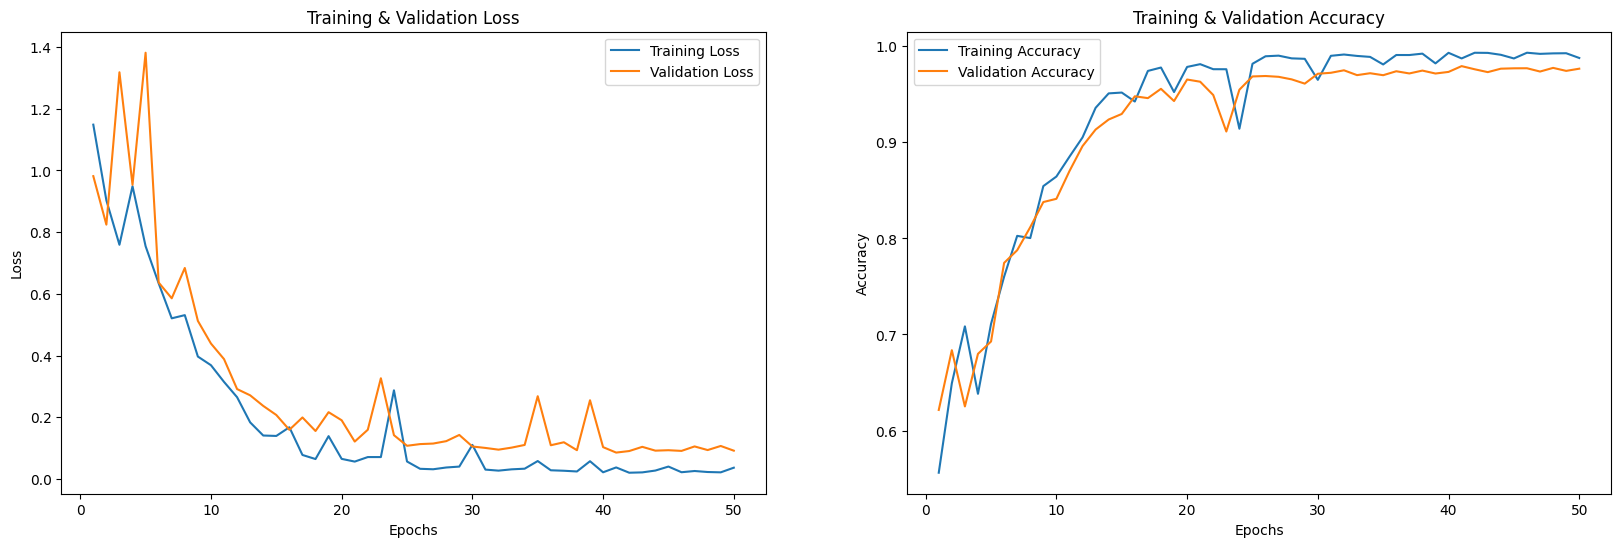

OutOfMemoryError: CUDA out of memory. Tried to allocate 59.47 GiB. GPU 0 has a total capacity of 79.25 GiB of which 18.76 GiB is free. Including non-PyTorch memory, this process has 60.48 GiB memory in use. Of the allocated memory 59.85 GiB is allocated by PyTorch, and 128.62 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [26]:
# 7) Plot history (Keras-style) ----
epochs_range = range(1, len(history["train_loss"]) + 1)
plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history["train_loss"], label="Training Loss")
plt.plot(epochs_range, history["val_loss"], label="Validation Loss")
plt.title("Training & Validation Loss")
plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history["train_acc"], label="Training Accuracy")
plt.plot(epochs_range, history["val_acc"], label="Validation Accuracy")
plt.title("Training & Validation Accuracy")
plt.xlabel("Epochs"); plt.ylabel("Accuracy"); plt.legend()

plt.show()

# 8) Example inference (probs & class names) ----
with torch.no_grad():
    xb = x_test_t.to(device)
    probs = torch.softmax(best_model(xb), dim=1).cpu().numpy()
    preds = probs.argmax(axis=1)

label_names = encoder.categories_[0]  # in the encoder's order
pred_labels = label_names[preds]
print("Example predicted labels:", pred_labels[:10])


Test loss: 0.0857  Test Accuracy: 97.93%
              precision    recall  f1-score   support

       angry       0.99      0.98      0.98      2031
     disgust       0.98      0.97      0.98      1995
        fear       0.97      0.97      0.97      1999
       happy       0.99      0.98      0.98      2069
     neutral       0.98      0.97      0.98      2015
         sad       0.97      0.99      0.98      2030
    surprise       0.99      0.99      0.99       983

    accuracy                           0.98     13122
   macro avg       0.98      0.98      0.98     13122
weighted avg       0.98      0.98      0.98     13122



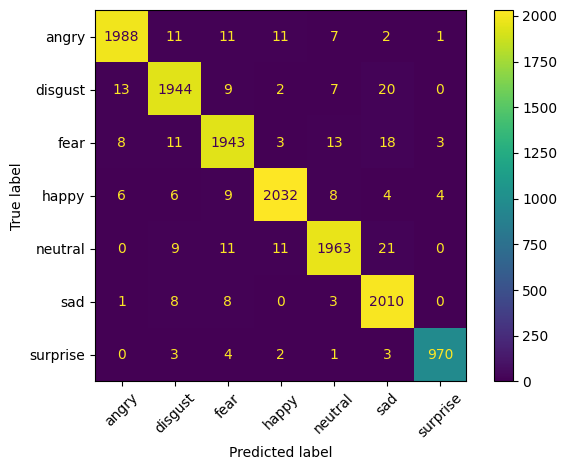

In [27]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Use the best checkpoint if you saved it; otherwise use the current model
model_to_eval = best_model if 'best_model' in locals() else model
model_to_eval.eval()

all_preds, all_true = [], []
test_loss_sum, total = 0.0, 0

with torch.no_grad():
    for xb, yb in val_loader:   # <- this is your test loader (built from x_test/y_test)
        xb, yb = xb.to(device), yb.to(device)
        logits = model_to_eval(xb)
        loss = criterion(logits, yb)

        test_loss_sum += loss.item() * yb.size(0)
        total += yb.size(0)

        preds = logits.argmax(dim=1)
        all_preds.append(preds.cpu().numpy())
        all_true.append(yb.cpu().numpy())

# Aggregate
y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_true)
test_loss = test_loss_sum / total
test_acc = (y_pred == y_true).mean()

print(f"Test loss: {test_loss:.4f}  Test Accuracy: {test_acc * 100:.2f}%")

# Map indices -> class names (same order as your OneHotEncoder)
target_names = encoder.categories_[0]
print(classification_report(y_true, y_pred, target_names=target_names))

# (Optional) Confusion matrix plot
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=target_names)
disp.plot(xticks_rotation=45)
plt.tight_layout()
plt.show()
